# Collect data

In [1]:
# Collect relevant content through the Reddit API.
import json
import praw
# PRAW documentation:
#  https://praw.readthedocs.io/en/stable/code_overview/reddit_instance.html

In [2]:
# IMPORTANT: enter proper access credential in the config-file;
# follow instructions in reddit_credentials_verify.ipynb
import config_reddit

In [3]:
# establish an API connection and verify read-only access
reddit = praw.Reddit(user_agent=f"Exploration script by /u/{config_reddit.user_name}",
                     client_id=config_reddit.app_id,
                     client_secret=config_reddit.app_secret)
reddit.read_only

True

In [13]:
# choose a subreddit of interest
# MODIFY this to what you prefer to analyze
#
# Example (take the string from the ending-part of the subreddit URL):
#  https://www.reddit.com/r/ebikes/
query_subreddit = 'ebike'

In [5]:
# decide how many top-"hot" posts to query
nposts = 50

In [6]:
# collect ids of the top posts within the chosen subreddit
post_ids = []
subreddit = reddit.subreddit(query_subreddit)
for p in subreddit.hot(limit = nposts):
    post_ids.append(p.id)
# check how many posts (submissions) were collected
len(post_ids)

50

In [7]:
# example post details
post_details = reddit.submission(id = post_ids[1])
print(post_details.title)
print(post_details.selftext)

Bike friendly neighborhoods start at the local level. You can make a difference.
1.	Transportation infrastructure policy is largely done at the local level. 
2.	A shockingly small number of people are actually involved in making this policy. 
3.	Individual Advocates can have a huge impact at the city level. 

Bottom line: Anyone can make a difference! 

Even if you can't afford to catch a local politicians ear via donation... or if you don't have the free time to show up at a city hall meeting... you can still be an educator/advocate on social media. 

**Education**

Youtube:

* [Why City Design is Important \(and Why I Hate Houston\) by Not Just Bikes](https://www.youtube.com/watch?v=uxykI30fS54)

* [The Ugly, Dangerous, and Inefficient Stroads found all over the US & Canada by Not Just Bikes](https://www.youtube.com/watch?v=ORzNZUeUHAM)

* [Bike lanes are not enough by City Beautiful](https://www.youtube.com/watch?v=p36skNda3KE)



Tiktok:

* [Phil Sustainability & Enviro](https://ww

In [8]:
# decide how many top comments to query per post;
# NOTE: larger number of comments may dilute the content (irrelevant text)
ncomments = 10

In [9]:
# function to collect post data
def collect_post_data(post_id, ncomments, reddit):
    psubm = reddit.submission(id = post_id)
    pdata = {'id': post_id, 'title': psubm.title, 'text': psubm.selftext}
    
    # collect first- and second-level comments
    pcomm = []
    psubcomm = []
    psubm.comments.replace_more(limit = ncomments)
    for top_comment in psubm.comments:
        pcomm.append(top_comment.body)
        for lev2_comment in top_comment.replies:
            psubcomm.append(lev2_comment.body)
    
    # assemble the data together
    pdata['comments_lev1'] = pcomm
    pdata['comments_lev2'] = psubcomm
    
    return pdata

In [11]:
# collect information for each post
posts_all = [collect_post_data(pid, ncomments, reddit) for pid in post_ids]

In [12]:
# save collected data to json file
file_out = f"raw_post_comment_data.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(posts_all, indent=2))

In [14]:
# Reddit data analysis task starter.
import html
import json
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# First collect the data in json-file (follow reddit_collect_data.ipynb); specify file name here
fjson = 'raw_post_comment_data.json'

In [16]:
# read json file with collected posts and comments
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

50

In [17]:
# data record example
data[0]

{'id': 'w09kb3',
 'title': 'Monthly /r/ebikes promo thread',
 'text': 'This  thread is for anyone selling ebike products or services. Our posting  guidelines do not apply here; sellers can directly link to product  pages, provide updates and coupon codes, advertise ebay auctions and  crowdfunding campaigns and do other promotional activities without  worrying that it could be seen as spam.\n\nFront page posts are still acceptable for sellers to post actual news, articles, reviews, blog posts, videos and pictures. But if it is clearly marketing then it probably belongs here. Regular readers can of course create new threads to ask about anything posted in here. \n\nNote for [/r/ebikes](https://www.reddit.com/r/ebikes)  readers: Posts here do not constitute endorsement by anyone, use your best judgement and ask around to find out what is right for you.',
 'comments_lev1': ['If anyone is in the market for an Aventon, here is a code for 5% off.\n\nhttps://prz.io/bpL4eK0Hv',
  "RadPowerBikes

In [18]:
# create pandas dataframe from post titles
# https://stackoverflow.com/a/43175477
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,Monthly /r/ebikes promo thread
1,Bike friendly neighborhoods start at the local...
2,The fact that a 750w motor turned me into a bi...
3,Dropped the kids off at school. Found a bridge...
4,I'm personally just fine puttering around at 2...
5,nice ride along the French Brittany coast
6,Picked up a pair of Priority Current E-Bikes f...
7,Bridge over the Huron River.
8,"Been busy with work, was able to paint tank an..."
9,Added a front fender and some cable management...


In [19]:
# add columns from other data fields: combine comment and sub-comment text
df_posts['post_id'] = [p['id'] for p in data]
df_posts['text'] = [p['text'] for p in data]
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data]
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data]
df_posts

,title,post_id,text,comments_lev1,comments_lev2
0,Monthly /r/ebikes promo thread,w09kb3,This thread is for anyone selling ebike produ...,"If anyone is in the market for an Aventon, her...","I know this is off topic, but I'm considering ..."
1,Bike friendly neighborhoods start at the local...,qa1nxo,1.\tTransportation infrastructure policy is la...,Started grassroots advocating a little over tw...,I’d love to hear your story and learn from you...
2,The fact that a 750w motor turned me into a bi...,w7p9so,,Im not riding a 750 but i understand the senti...,I don't own a car so walking and biking are my...
3,Dropped the kids off at school. Found a bridge...,w7rwzb,,I think the versatility of a mid drive makes i...,Its been well worth it for me. Besides picking...
4,I'm personally just fine puttering around at 2...,w78jeb,,"Living in London, 20mph is better than the ave...",20mph would be fine if I actually had bike lan...
5,nice ride along the French Brittany coast,w7kuh9,,What bike is that? It looks awesome! One of my...,"It’s an Electra Straight 8, double t fork 3 sp..."
6,Picked up a pair of Priority Current E-Bikes f...,w7unkb,,You're living the good life! Who gets to carr...,I get to! We made a grocery run earlier and I’...
7,Bridge over the Huron River.,w7uivw,,,
8,"Been busy with work, was able to paint tank an...",w73olp,,Having the front sprocket so far from the swin...,Good eye. Seems like the chain would break wi...
9,Added a front fender and some cable management...,w7pfik,,Why is your fork tube so long?,It’s an extender so I could raise the handleba...


In [20]:
# text cleaning function: see prior class modules
stop_words = set(stopwords.words('english'))

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [21]:
# add clean text column with combined comments of both levels
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean
0,Monthly /r/ebikes promo thread,w09kb3,This thread is for anyone selling ebike produ...,"If anyone is in the market for an Aventon, her...","I know this is off topic, but I'm considering ...",thread anyone selling ebike products services ...
1,Bike friendly neighborhoods start at the local...,qa1nxo,1.\tTransportation infrastructure policy is la...,Started grassroots advocating a little over tw...,I’d love to hear your story and learn from you...,transportation infrastructure policy largely d...
2,The fact that a 750w motor turned me into a bi...,w7p9so,,Im not riding a 750 but i understand the senti...,I don't own a car so walking and biking are my...,im riding 750 understand sentiment barely driv...
3,Dropped the kids off at school. Found a bridge...,w7rwzb,,I think the versatility of a mid drive makes i...,Its been well worth it for me. Besides picking...,think versatility mid drive makes like suv min...
4,I'm personally just fine puttering around at 2...,w78jeb,,"Living in London, 20mph is better than the ave...",20mph would be fine if I actually had bike lan...,living london 20mph better average traffic spe...
5,nice ride along the French Brittany coast,w7kuh9,,What bike is that? It looks awesome! One of my...,"It’s an Electra Straight 8, double t fork 3 sp...",bike looks awesome one favourite places find l...
6,Picked up a pair of Priority Current E-Bikes f...,w7unkb,,You're living the good life! Who gets to carr...,I get to! We made a grocery run earlier and I’...,living good life gets carry snacks get made gr...
7,Bridge over the Huron River.,w7uivw,,,,
8,"Been busy with work, was able to paint tank an...",w73olp,,Having the front sprocket so far from the swin...,Good eye. Seems like the chain would break wi...,front sprocket far swingarm pivot point would ...
9,Added a front fender and some cable management...,w7pfik,,Why is your fork tube so long?,It’s an extender so I could raise the handleba...,fork tube long extender could raise handlebars...


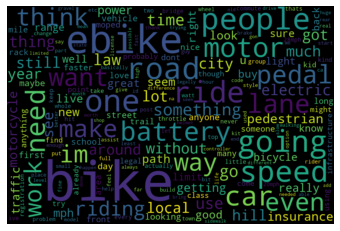

In [24]:
# most common keywords
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
text_combined = ' '.join(df_posts['text_clean'])
wc = WordCloud(width=1200, height=800, max_font_size=200, collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [25]:
# extract keyword counts
# https://stackoverflow.com/questions/60234036/python-word-count-from-wordcloud
kwords = WordCloud().process_text(text_combined)
kwords

{'thread': 2,
 'anyone': 18,
 'selling': 5,
 'ebike': 105,
 'posting': 2,
 'guidelines': 1,
 'apply': 3,
 'directly': 4,
 'link': 7,
 'product': 4,
 'provide': 5,
 'updates': 1,
 'coupon': 4,
 'advertise': 2,
 'ebay': 1,
 'auctions': 1,
 'crowdfunding': 1,
 'campaigns': 1,
 'promotional': 1,
 'activities': 1,
 'without': 29,
 'worrying': 2,
 'seen': 9,
 'spam': 1,
 'front': 13,
 'page': 3,
 'still': 30,
 'acceptable': 1,
 'post': 13,
 'actual': 5,
 'blog': 2,
 'clearly': 3,
 'marketing': 1,
 'probably': 16,
 'belongs': 1,
 'regular': 3,
 'readers': 2,
 'course': 4,
 'create': 3,
 'new': 25,
 'ask': 5,
 'anything': 17,
 'posted': 4,
 'note': 2,
 'constitute': 1,
 'endorsement': 1,
 'use': 32,
 'best': 8,
 'judgement': 1,
 'around': 28,
 'find': 15,
 'right': 22,
 'market': 3,
 'aventon': 2,
 'code': 7,
 'currently': 3,
 'running': 8,
 'promo': 1,
 'radrover': 1,
 'plus': 6,
 'radrunner': 5,
 'needed': 10,
 'purchased': 2,
 'radmini4': 2,
 'model': 11,
 'radexpand': 3,
 'love': 17,
 'rad

In [26]:
# transform that dictionary into a pandas DataFrame
df_kwords = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count']).set_index('keyword')
df_kwords

,count
keyword,
thread,2
anyone,18
selling,5
ebike,105
posting,2
...,...
main gear,4
ride1up prodigy,2
rode miles,3


# Data Visualization of Keyword 

<AxesSubplot:xlabel='keyword'>

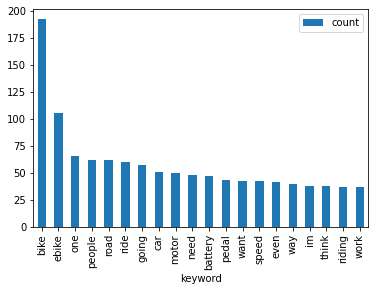

In [27]:
# plot a bar chart with the top keywords
%matplotlib inline
df_kwords.sort_values(by='count', ascending=False).head(20).plot.bar()

In [30]:
# NLTK collocations search (words occuring together): bigrams
# https://www.nltk.org/howto/collocations.html
# http://www.nltk.org/api/nltk.html#nltk.util.bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

In [31]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [32]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('feel', 'free'), 3),
 (('coupon', 'code'), 3),
 (('rad', 'power'), 3),
 (('looks', 'like'), 6),
 (('first', 'ebike'), 6),
 (('got', 'radrunner'), 3),
 (('local', 'level'), 3),
 (('make', 'difference'), 3),
 (('bike', 'lanes'), 13),
 (('bike', 'rack'), 9),
 (('road', 'bike'), 7),
 (('bike', 'path'), 8),
 (('bus', 'line'), 3),
 (('bike', 'lane'), 19),
 (('would', 'like'), 5),
 (('local', 'businesses'), 3),
 (('bike', 'infrastructure'), 7),
 (('city', 'bike'), 3),
 (('something', 'like'), 4),
 (('gon', 'na'), 10),
 (('get', 'work'), 5),
 (('even', 'though'), 4),
 (('never', 'going'), 3),
 (('would', 'need'), 3),
 (('would', 'love'), 3),
 (('get', 'people'), 3),
 (('seems', 'like'), 4),
 (('2', 'months'), 5),
 (('front', 'rear'), 4),
 (('every', 'day'), 4),
 (('mid', 'drive'), 4),
 (('20', 'mph'), 4),
 (('bikes', 'people'), 3),
 (('could', 'legally'), 4),
 (('get', 'motorcycle'), 3),
 (('lot', 'people'), 3),
 (('make', 'sure'), 6),
 (('dont', 'want'), 3),
 (('im', 'sure'), 4),
 (('cycle

In [33]:
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq

,count
keyphrase,
bike lane,19
bike lanes,13
gon na,10
top speed,9
bike rack,9
...,...
without pedaling,3
going faster,3
ride way,3


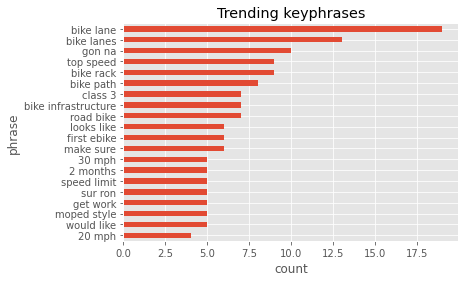

In [34]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()